# ATP Tennis Predictions Using Player History/Matchup Data

In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/7-apt_advanced_feature_engineering.ipynb), we created new datasets with player history leading up to the match as well as matchup history between the 2 players. Player history is based on the most recent 5 matches played and matchup history is also based on the most recent 5 matches played

In this notebook, we will run our models with these datasets to see if we get improvements from the new data

Our best performing model so far is Random Forest using our basic diff dataset where we diffed available player stats between the 2 players and created features from them and using data from 1998 to 2019

### Results from Random Forest using diff dataset:

Random Forest Accruacy score: 0.8524918780673256

```
              precision    recall  f1-score   support

        Loss       0.82      0.90      0.86      7115
         Win       0.89      0.81      0.85      7352

    accuracy                           0.85     14467
   macro avg       0.86      0.85      0.85     14467
weighted avg       0.86      0.85      0.85     14467
```

# Summary
* Surprisingly, adding match data leading up to the match as well as match-up data didn't make much of a difference.
* Random Forest is still doing the best out of all models and the 2 datasets that we ran in this notebook. It came back with 84.5% accuracy score using the player stats diff dataset with history/matchup data. Although this is still performing slightly below our 85.2% accuracy score with Random Forest using only the player stats diff dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pickle
import json

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# files
DATASET_DIR = '../datasets'
FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff-matchup5.csv'
FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-matchup5.csv'
FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff-ohe-matchup5.csv'
FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2019

MODEL_DIR = '../models'
MODEL_FILE_KNN = f'{MODEL_DIR}/knn-{START_YEAR}-{END_YEAR}-diff-matchup5.pkl'
MODEL_FILE_LR = f'{MODEL_DIR}/lr-{START_YEAR}-{END_YEAR}-diff-matchup5.pkl'
MODEL_FILE_RF = f'{MODEL_DIR}/rf-{START_YEAR}-{END_YEAR}-diff-matchup5.pkl'
MODEL_FILE_KNN_OHE = f'{MODEL_DIR}/knn-{START_YEAR}-{END_YEAR}-diff-ohe-matchup5.pkl'
MODEL_FILE_LR_OHE = f'{MODEL_DIR}/lr-{START_YEAR}-{END_YEAR}-diff-ohe-matchup5.pkl'
MODEL_FILE_RF_OHE = f'{MODEL_DIR}/rf-{START_YEAR}-{END_YEAR}-diff-ohe-matchup5.pkl'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [2]:
def analyze_predictions(model, X_test, y_test, y_predict, y_predict_proba=None):
    print(f'Model Score: {model.score(X_test, y_test)}')
    
    if y_predict_proba:
        print(roc_auc_score(y_test, y_predict_proba))
    
    print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))
    cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
    print(cm)
    sns.heatmap(cm, annot=True)
    
    

def plot_2d(X_test, y_predict):
    """
    Use PCA to dimensionality reduction then plot win vs loses
    :param: X_test - test features
    :param: y_predict - predictions from model
    """
    
    # normalize our data first before using PCA so weights are the same for all variables
    mms = MinMaxScaler()
    normalized_df = X_test.copy()
    for col in normalized_df.columns:
        normalized_col = mms.fit_transform([normalized_df[col].values])
        normalized_df[col] = normalized_col[-1]
    

    # reduce X to 2D
    X_test_2d = pd.DataFrame(PCA(n_components=2).fit_transform(X_test))

    # let's figure out which ones of these are predicted Wins
    wins = X_test_2d[y_predict == 1]

    # entries that are predicted losses
    losses = X_test_2d[y_predict == 0]

    f, a = plt.subplots(1, 1, figsize=(20,5))
    p = sns.scatterplot(x=0, y=1, data=losses, ax=a, color='r', alpha=0.25)
    p = sns.scatterplot(x=0, y=1, data=wins, ax=a, color='b', alpha=0.25)


# Reading in our data - diff data + history/matchup data

In [3]:
# extract features and labels
features = pd.read_csv(f'{FEATURE_FILE_DIFF}')
labels = features[LABEL_COL].copy()
features = features.drop([LABEL_COL], axis=1)

In [4]:
np.sort(features.columns)

array(['age_diff', 'draw_size', 'ht_diff', 'p1', 'p1_games_lost',
       'p1_games_won', 'p1_games_won_percentage', 'p1_hand', 'p1_ioc',
       'p1_losses', 'p1_matchup_games', 'p1_matchup_games_won_percentage',
       'p1_matchup_losses', 'p1_matchup_sets',
       'p1_matchup_sets_won_percentage', 'p1_matchup_win_percentage',
       'p1_matchup_wins', 'p1_sets_lost', 'p1_sets_won',
       'p1_sets_won_percentage', 'p1_win_percentage', 'p1_wins', 'p2',
       'p2_games_lost', 'p2_games_won', 'p2_games_won_percentage',
       'p2_hand', 'p2_ioc', 'p2_losses', 'p2_matchup_games',
       'p2_matchup_games_won_percentage', 'p2_matchup_losses',
       'p2_matchup_sets', 'p2_matchup_sets_won_percentage',
       'p2_matchup_win_percentage', 'p2_matchup_wins', 'p2_sets_lost',
       'p2_sets_won', 'p2_sets_won_percentage', 'p2_win_percentage',
       'p2_wins', 'rank_diff', 'round_label', 'seed_diff',
       'surface_label', 'tourney_id_label', 'tourney_level_label',
       'tourney_month', 't

In [5]:
DELETE_COLS = ["p1_games_lost", "p1_games_won", "p1_losses", "p1_matchup_games", "p1_matchup_losses", "p1_matchup_sets", "p1_matchup_wins", "p1_sets_lost", "p1_sets_won", "p1_wins"]
DELETE_COLS.extend([col.replace("p1", "p2") for col in DELETE_COLS])
DELETE_COLS

['p1_games_lost',
 'p1_games_won',
 'p1_losses',
 'p1_matchup_games',
 'p1_matchup_losses',
 'p1_matchup_sets',
 'p1_matchup_wins',
 'p1_sets_lost',
 'p1_sets_won',
 'p1_wins',
 'p2_games_lost',
 'p2_games_won',
 'p2_losses',
 'p2_matchup_games',
 'p2_matchup_losses',
 'p2_matchup_sets',
 'p2_matchup_wins',
 'p2_sets_lost',
 'p2_sets_won',
 'p2_wins']

In [6]:
features = features.drop(DELETE_COLS, axis=1)
features.columns

Index(['age_diff', 'draw_size', 'ht_diff', 'p1', 'p1_hand', 'p1_ioc', 'p2',
       'p2_hand', 'p2_ioc', 'rank_diff', 'round_label', 'seed_diff',
       'surface_label', 'tourney_id_label', 'tourney_level_label',
       'tourney_month', 'tourney_year', 'p1_games_won_percentage',
       'p1_matchup_games_won_percentage', 'p1_matchup_sets_won_percentage',
       'p1_matchup_win_percentage', 'p1_sets_won_percentage',
       'p1_win_percentage', 'p2_games_won_percentage',
       'p2_matchup_games_won_percentage', 'p2_matchup_sets_won_percentage',
       'p2_matchup_win_percentage', 'p2_sets_won_percentage',
       'p2_win_percentage'],
      dtype='object')

In [7]:
# train our model
X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, random_state=RSTATE)

## Logistic Regression

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Model Score: 0.6920534268753373
              precision    recall  f1-score   support

        Loss       0.70      0.66      0.68      7378
         Win       0.68      0.72      0.70      7446

    accuracy                           0.69     14824
   macro avg       0.69      0.69      0.69     14824
weighted avg       0.69      0.69      0.69     14824

      Loss   Win
Loss  4888  2490
Win   2075  5371


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.9s finished


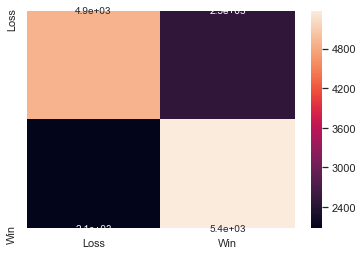

In [8]:
lr = LogisticRegression(n_jobs = N_JOBS, verbose = 1, max_iter = MAX_ITER, random_state = RSTATE, solver = 'lbfgs').fit(X_train, y_train)
y_predict_lr = lr.predict(X_test)

analyze_predictions(lr, X_test, y_test, y_predict_lr)

In [9]:
pickle.dump(lr, open(MODEL_FILE_LR, 'wb'))

## KNN

Model Score: 0.6107663248785753
              precision    recall  f1-score   support

        Loss       0.61      0.61      0.61      7378
         Win       0.61      0.61      0.61      7446

    accuracy                           0.61     14824
   macro avg       0.61      0.61      0.61     14824
weighted avg       0.61      0.61      0.61     14824

      Loss   Win
Loss  4499  2879
Win   2891  4555


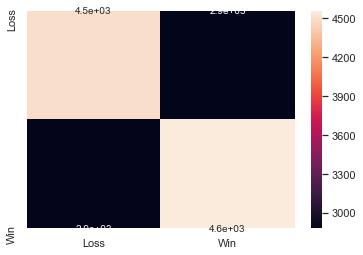

In [10]:
knn = KNeighborsClassifier(n_jobs = N_JOBS).fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)

analyze_predictions(knn, X_test, y_test, y_predict_knn)

In [11]:
pickle.dump(knn, open(MODEL_FILE_KNN, 'wb'))

## Random Forest

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Model Score: 0.8403264975715057
              precision    recall  f1-score   support

        Loss       0.81      0.88      0.85      7378
         Win       0.87      0.80      0.83      7446

    accuracy                           0.84     14824
   macro avg       0.84      0.84      0.84     14824
weighted avg       0.84      0.84      0.84     14824

      Loss   Win
Loss  6517   861
Win   1506  5940


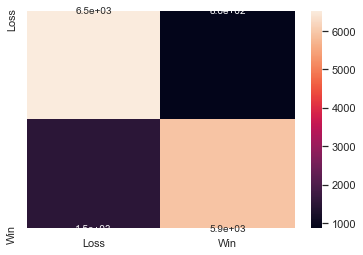

In [12]:
rf = RandomForestClassifier(random_state=RSTATE, verbose=1).fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

analyze_predictions(rf, X_test, y_test, y_predict_rf)

In [13]:
pickle.dump(rf, open(MODEL_FILE_RF, 'wb'))

# Reading in One Hot Encoded Data With History/Matchup

In [14]:
# extract features and labels
features_ohe = pd.read_csv(f'{FEATURE_FILE_DIFF_OHE}')
labels_ohe = features_ohe[LABEL_COL].copy()
features_ohe = features_ohe.drop([LABEL_COL], axis=1)

# drop other feature columns
features_ohe = features_ohe.drop(DELETE_COLS, axis=1)

# train our model
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = \
        train_test_split(features_ohe, labels, random_state=RSTATE)

## Logistic Regression

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.2min finished


Model Score: 0.6962358337830545
              precision    recall  f1-score   support

        Loss       0.70      0.67      0.69      7378
         Win       0.69      0.72      0.70      7446

    accuracy                           0.70     14824
   macro avg       0.70      0.70      0.70     14824
weighted avg       0.70      0.70      0.70     14824

      Loss   Win
Loss  4975  2403
Win   2100  5346


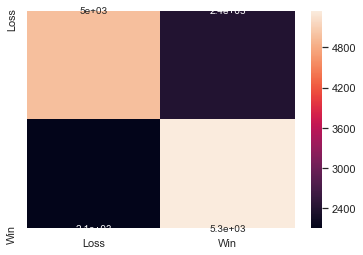

In [15]:
lr_ohe = LogisticRegression(n_jobs = N_JOBS, verbose = 1, max_iter = MAX_ITER, random_state = RSTATE, solver = 'lbfgs').fit(X_train_ohe, y_train_ohe)
y_predict_lr_ohe = lr_ohe.predict(X_test_ohe)

analyze_predictions(lr_ohe, X_test_ohe, y_test_ohe, y_predict_lr_ohe)

In [16]:
pickle.dump(lr_ohe, open(MODEL_FILE_LR_OHE, 'wb'))

## KNN

Model Score: 0.8416756610901241
              precision    recall  f1-score   support

        Loss       0.83      0.85      0.84      7378
         Win       0.85      0.83      0.84      7446

    accuracy                           0.84     14824
   macro avg       0.84      0.84      0.84     14824
weighted avg       0.84      0.84      0.84     14824

      Loss   Win
Loss  6308  1070
Win   1277  6169


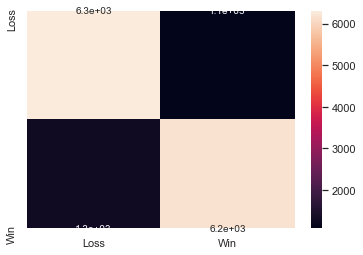

In [17]:
knn_ohe = KNeighborsClassifier(n_jobs = N_JOBS).fit(X_train_ohe, y_train_ohe)
y_predict_knn_ohe = knn_ohe.predict(X_test_ohe)

analyze_predictions(knn_ohe, X_test_ohe, y_test_ohe, y_predict_knn_ohe)

In [18]:
pickle.dump(knn_ohe, open(MODEL_FILE_KNN_OHE, 'wb'))

## Random Forest

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7496627091203454
              precision    recall  f1-score   support

        Loss       0.72      0.80      0.76      7378
         Win       0.78      0.69      0.74      7446

    accuracy                           0.75     14824
   macro avg       0.75      0.75      0.75     14824
weighted avg       0.75      0.75      0.75     14824

      Loss   Win
Loss  5939  1439
Win   2272  5174


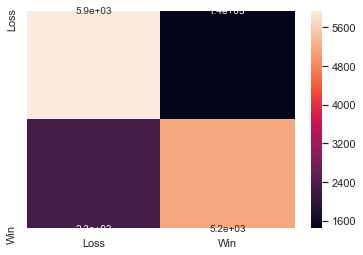

In [19]:
rf_ohe = RandomForestClassifier(random_state=RSTATE, verbose=1).fit(X_train_ohe, y_train_ohe)
y_predict_rf_ohe = rf_ohe.predict(X_test_ohe)

analyze_predictions(rf_ohe, X_test_ohe, y_test_ohe, y_predict_rf_ohe)

In [20]:
pickle.dump(rf_ohe, open(MODEL_FILE_RF_OHE, 'wb'))

# Summarize Accuracy for our Models and Datasets

All dataset from 1998 to 2019

Text(0.5, 1.0, 'Model Accuracy')

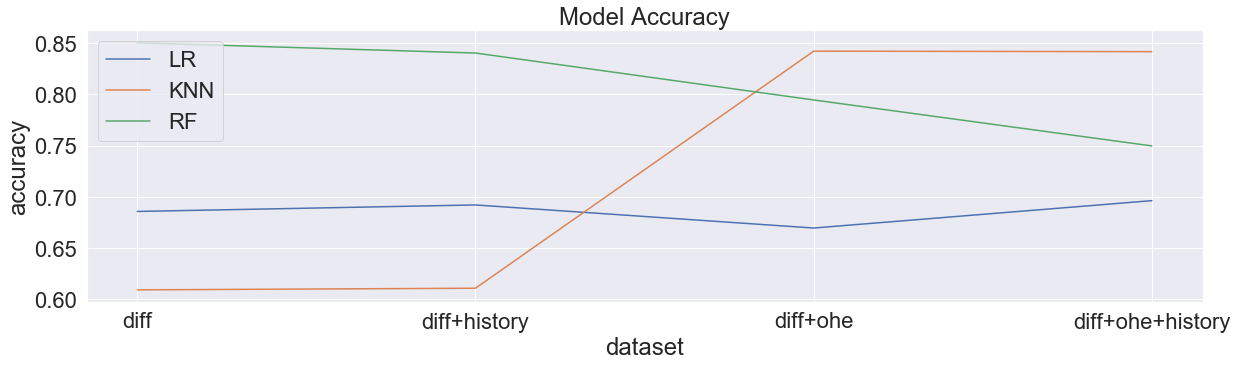

In [30]:
REPORT_FILE = '../reports/summary.csv'
summary = pd.read_csv(REPORT_FILE)

f, a = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x="dataset", y="accuracy", data=summary[summary.model == "LR"], label="LR")
sns.lineplot(x="dataset", y="accuracy", data=summary[summary.model == "KNN"], label="KNN")
sns.lineplot(x="dataset", y="accuracy", data=summary[summary.model == "RF"], label="RF")
a.set_title("Model Accuracy")


# Analyze What KNN is doing with the diff + history/match-up Dataset

In [22]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


## Feature Importance Summary


* Seed difference and rank difference are the most important features used to predict wins or losses
* Draw size is the next most important
* Height difference, What level of tournament, and which round of the match seems to contribute approximately the same to the prediction
* games won for either players leading up the match seems to be the most predictive feature out of the historical data
* games won also in previous matchup seems to be better predictors than matchup won percentage - I guess this would give us more granular detail about previous matchups than just wins and losses

## Compare Our best KNN and RF models

NOTE: Here, we are comparing KNN using the diff + one hot encoding + history/match-up dataset (84.2% accuracy) with RF model using diff dataset (85.2% accuracy)

    
* both used seed and rank difference as the most important features
* RF relies on the round of match (round_label) before using draw size to make prediction
* height difference was pretty low in feature importance in RF but it's the 4th most important feature for KNN
* KNN also used the player 2's ID as part of the prediction - not sure if we should do something here?

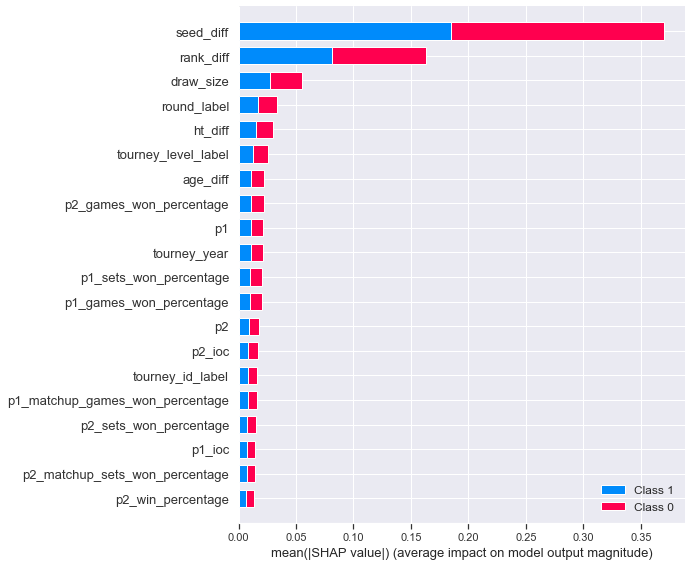

In [23]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

### RF Feature Importance with diff Dataset (from previous notebook)

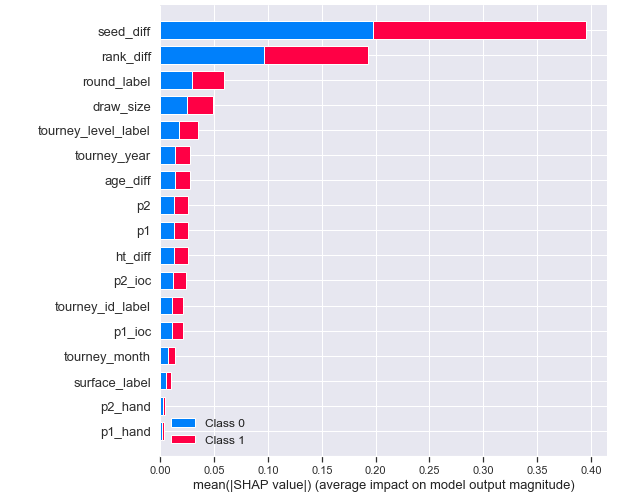

In [24]:
from IPython.display import Image
Image(filename='../images/RF_feature_importance-diff.png') 

### Let's look at a correct prediction

Correctly predicted a win

player 1 is ranked higher than player 2 so we would expect player 1 to win, although this player's recording coming into the match wasn't very good with 0 sets won in the last 5 macthes and only 32% games won leading up to the match which means the player has a losing recording coming into this match

In [25]:
# correctly predict a win
win_index = 1
print(f'Truth Label: {y_test.iloc[win_index]} Predicted Label: {y_predict_knn_ohe[win_index]}')
shap.force_plot(explainer.expected_value[1], shap_values[1][win_index][:], X_test.iloc[win_index,:], feature_names=X_test.columns)

Truth Label: 1.0 Predicted Label: 1.0


Correctly predicted a loss

Player 1 was ranked lower than player 2. This was a grand salm as the draw size was 128. Previous matchup, it looks like player 1 has never beaten player 2

In [26]:
# correct predict loss
loss_index = 100
print(f'Truth Label: {y_test.iloc[loss_index]} Predicted Label: {y_predict_knn_ohe[loss_index]}')
shap.force_plot(explainer.expected_value[0], shap_values[0][loss_index][:], X_test.iloc[loss_index,:], feature_names=X_test.columns)

Truth Label: 0.0 Predicted Label: 0.0


### Incorrect Predictions

Incorrectly predicted a loss but player 1 actually won the match

This was an upset. 

* There is a pretty big seed difference. Postiive number means that player 1 is ranked much lower than player 2. 
* The model picked tournament id as well as round and draw size the make the prediction over other metrics - ie, historical data to predict the win

In [27]:
# predicted loss but p1 actually won

incorrect_win_index = 13
print(f'Truth Label: {y_test.iloc[incorrect_win_index]} Predicted Label: {y_predict_knn_ohe[incorrect_win_index]}')
shap.force_plot(explainer.expected_value[1], shap_values[1][incorrect_win_index][:], X_test.iloc[incorrect_win_index,:], feature_names=X_test.columns)

Truth Label: 1.0 Predicted Label: 0.0


Model incorrectly predicted a win but p1 actually lost the match

The seed difference here is realtively low compared to other entries we are looking at here. This is not a grand slam as the draw size is 64. Player games won coming into the match is at about 40% which means the player probably has a losing record.

Interestingly enough, the model used the player 2 id as part of the prediction as part of losing.

In [28]:
incorrect_win_index = 14
print(f'Truth Label: {y_test.iloc[incorrect_win_index]} Predicted Label: {y_predict_knn_ohe[incorrect_win_index]}')
shap.force_plot(explainer.expected_value[0], shap_values[0][incorrect_win_index][:], X_test.iloc[incorrect_win_index,:], feature_names=X_test.columns)

Truth Label: 0.0 Predicted Label: 1.0


### Let's look at the correlation and correlation matrix of our variables

* Surprisingly, we are not seeing strong correlations between many variables. The only variables we see with strong correlations are historical data for win percetage, sets won, and games won. This makes sense. If you have a high winning percentage coming into the tournament, you would expect that the number of sets and games won would be higher as well.
* Other correlations
    * draw size and round - this also makes sense as bigger draw sizes, you would have more rounds
    * seed diff and draw size - this also somewhat makes sense. Tournaments generally match up seeded players with unseeded players, so you would expect in the first couple rounds, a larger difference in seed and rank difference
    * I would have expected some of the correlation between both seed and rank diff and matchup win percentage. However, I see a slight negative correlation between seed diff and history percentages but not with rank

Text(0.5, 1, 'Correlation Matrix')

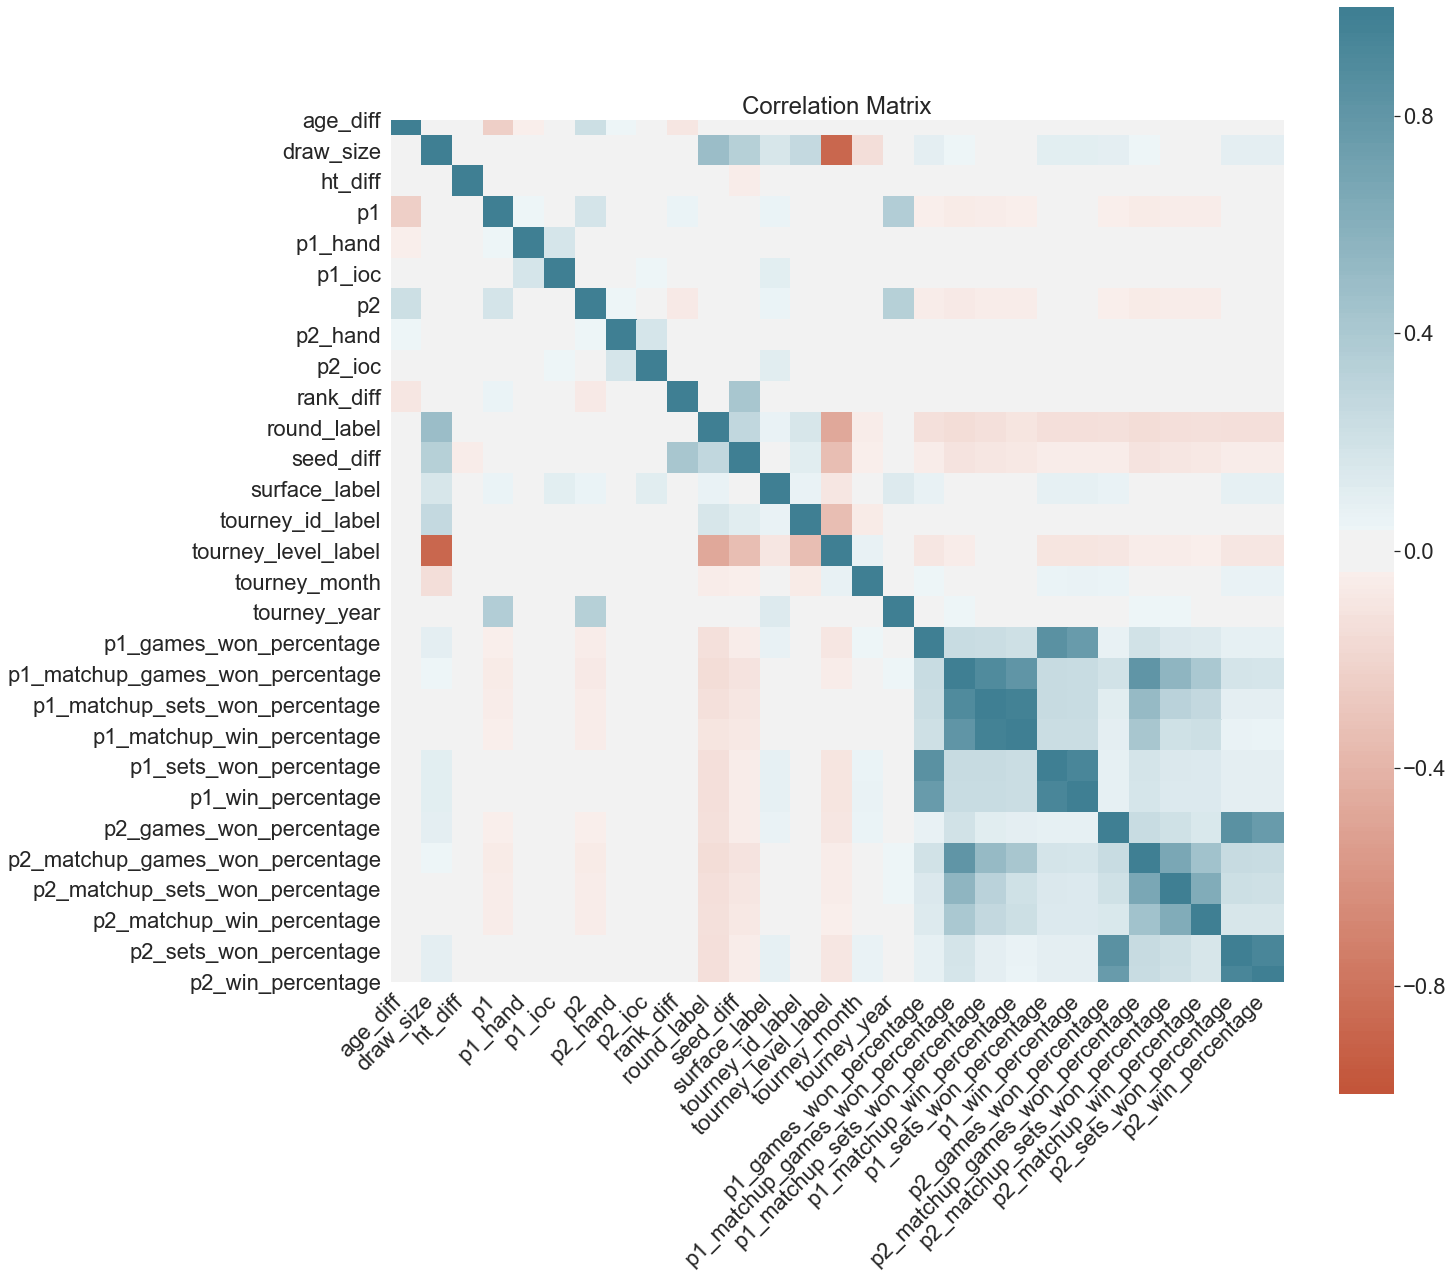

In [29]:
sns.set(font_scale=2)  # crazy big


corr = features.corr()

f, a = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
ax.set_title("Correlation Matrix")
